
# Export Promptflow Outputs

This script is used for downloading all the run info needed and merge them together in local environments.


## Prerequisite
Make sure all required libraries are installed.Use command below to install azureml.core:

    pip install azureml-core

In [2]:
import csv
import json
import logging
import requests
from pathlib import Path
from azureml.core import Workspace

Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (packaging 23.2 (/usr/local/Caskroom/miniconda/base/envs/rag-promptflow/lib/python3.10/site-packages), Requirement.parse('packaging<=23.0,>=20.0')).


## Get workspace
Get gonnections to workspace with personal token.

In [3]:
# Get a logger which allows us to log events that occur when running the program.
logger = logging.getLogger("myLogger")
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(asctime)s %(message)s")
ch = logging.StreamHandler()
ch.setFormatter(formatter)
ch.setLevel(logging.DEBUG)
if not logger.handlers:
    logger.addHandler(ch)

# Get the workspace associated with your personal token and get the relavant datastore.
subscription_id = "15ae9cb6-95c1-483d-a0e3-b1a1a3b06324"
resource_group = "copilot-demo-eastus"
workspace_name = "copilot-demo-eastus"
ws = Workspace.get(workspace_name, subscription_id=subscription_id, resource_group=resource_group)
region = ws.location
default_datastore = ws.get_default_datastore()

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


## Define utils
Define functions for downloading and loading run info.

In [4]:
# Get run infor for the given run_id
def get_run_info(run_id):
    logger.info(f"Getting Run Info for Run: {run_id}")
    run = ws.get_run(run_id=run_id)
    display_name = run.display_name
    input_run_id = run.properties.get('azureml.promptflow.input_run_id')
    return display_name, input_run_id

# Get the output asset id for the given run_id and asset_name
def get_output_asset_id(run_id, asset_name):
    logger.info(f"Getting Output Asset Id for Run {run_id}")
    if region == "centraluseuap":
        url = f"https://int.api.azureml-test.ms/history/v1.0/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.MachineLearningServices/workspaces/{workspace_name}/rundata"
    else:
        url = f"https://ml.azure.com/api/{region}/history/v1.0/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.MachineLearningServices/workspaces/{workspace_name}/rundata"
    payload = {
        "runId": run_id,
        "selectRunMetadata": True
    }
    response = requests.post(url, json=payload, headers=ws._auth.get_authentication_header())
    if response.status_code != 200:
        raise Exception(f"Failed to get output asset id for run {run_id} because RunHistory API returned status code {response.status_code}. Response: {response.text}")
    output_asset_id = response.json()["runMetadata"]["outputs"][asset_name]["assetId"]
    return output_asset_id

# Get the asset path for the given asset_id
def get_asset_path(asset_id):
    logger.info(f"Getting Asset Path for Asset Id {asset_id}")
    if region == "centraluseuap":
        url = f"https://int.api.azureml-test.ms/data/v1.0/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.MachineLearningServices/workspaces/{workspace_name}/dataversion/getByAssetId"
    else:
        url = f"https://ml.azure.com/api/{region}/data/v1.0/subscriptions/{subscription_id}/resourceGroups/{resource_group}/providers/Microsoft.MachineLearningServices/workspaces/{workspace_name}/dataversion/getByAssetId"
    payload = {
        "value": asset_id,
    }
    response = requests.post(url, json=payload, headers=ws._auth.get_authentication_header())
    if response.status_code != 200:
        raise Exception(f"Failed to get asset path for asset id {asset_id} because Data API returned status code {response.status_code}. Response: {response.text}")
    data_uri = response.json()["dataVersion"]["dataUri"]
    relative_path = data_uri.split("/paths/")[-1]
    return relative_path

# Get the flow artifact relative path for the given run_id
def get_flow_artifact_relative_path(run_id):
    logger.info(f"Getting Flow Artifact Relative Path for Run {run_id}")
    try:
        flow_artifact_asset_id = get_output_asset_id(run_id, "debug_info")
        relative_path = get_asset_path(flow_artifact_asset_id)
        relative_path += "flow_artifacts/"
        return relative_path
    except Exception as e:
        logger.warning("`debug_info` output assets is not available, maybe because the job ran on old version runtime, trying to get `flow_outputs` output asset instead.")
        output_asset_id = get_output_asset_id(run_id, "flow_outputs")
        relative_path = get_asset_path(output_asset_id)
        return relative_path.replace("flow_outputs", "flow_artifacts")

# Download flow artifacts for the given run_id
def download_flow_artifacts(run_id, blob_prefix):
    logger.info(f"Downloading Flow Artifacts for Run {run_id}")
    target_dir = f"./downloads/{run_id}"
    default_datastore.download(target_dir, prefix=blob_prefix, overwrite=True)
    return target_dir

# Load flow artifacts of the run from the given local_dir
def load_flow_artifacts(local_dir, run_display_name):
    logger.info(f"Loading Flow Artifacts of {run_display_name} from {local_dir}")
    flow_artifacts = {}
    p = Path(local_dir)
    for file_path in p.glob("**/*.jsonl"):
        with open(file_path) as fp:
            for line in fp:
                line_record = json.loads(line)
                line_number = line_record.get("line_number")
                run_info = line_record.get("run_info") or {}
                status = run_info.get("status")
                outputs = run_info.get("output") or {}
                inputs = run_info.get("inputs") or {}
                modified_inputs = {f"inputs.{k}": v for k, v in inputs.items()}
                record = {
                    "Line number": line_number,
                    "Run": run_display_name,
                    "Status": status,
                    **modified_inputs,
                    **outputs
                }
                flow_artifacts[line_number] = record
    return flow_artifacts

# Get required info for the given run_id
def get_required_info(run_id):
    logger.info(f"Processing Run: {run_id}")
    display_name, input_run_id = get_run_info(run_id)
    flow_artifact_relative_path = get_flow_artifact_relative_path(run_id)

    target_dir = download_flow_artifacts(run_id, flow_artifact_relative_path)
    flow_artifacts = load_flow_artifacts(target_dir, display_name)
    return {
        "run_id": run_id,
        "display_name": display_name,
        "input_run_id": input_run_id,
        "flow_artifacts": flow_artifacts
    }

# Update downstream flow artifacts with the given display_name
def update_downstread_flow_artifacts(flow_artifacts, display_name):
    updated_flow_artifacts = {}
    for line_number, line_record in flow_artifacts.items():
        updated_line_record = {}
        for k, v in line_record.items():
            if k == "Run" or k == "Status" or k == "Line number":
                continue
            else:
                updated_line_record[f"{k}({display_name})"] = v
        updated_flow_artifacts[line_number] = updated_line_record
    return updated_flow_artifacts

# Merge flow artifacts for the given run_infos, joining flow artifacts with the same line number
def merge_flow_artifacts(run_infos: list):
    run_info_dict = {run_info["run_id"]: run_info for run_info in run_infos}
    main_flow_infos = []
    for run_id, run_info in run_info_dict.items():
        if run_info["input_run_id"] is None:
            main_flow_infos.append(run_info)
        else:
            input_run_id = run_info["input_run_id"]
            if input_run_id in run_info_dict:
                input_run_info = run_info_dict[input_run_id]
                updated_flow_artifacts = update_downstread_flow_artifacts(run_info["flow_artifacts"], run_info["display_name"])
                for line_number, updated_flow_artifact in updated_flow_artifacts.items():
                    if line_number in input_run_info["flow_artifacts"]:
                        input_run_info["flow_artifacts"][line_number].update(updated_flow_artifact)
            else:
                # Input Run is not included, treat this run as main flow
                main_flow_infos.append(run_info)
    
    merge_result = []
    for main_flow_info in main_flow_infos:
        merge_result += list(main_flow_info["flow_artifacts"].values())
    merge_result = sorted(merge_result, key=lambda x: f"{x['Line number']}{x['Run']}")
    return merge_result

# Convert the given jsonl file to csv file
def jsonl_to_csv(jsonl_path, csv_path):
    max_keys = []
    with open(jsonl_path, "r") as jsonl_file:
        for line in jsonl_file:
            row = json.loads(line)
            if len(row.keys()) > len(max_keys):
                max_keys = list(row.keys())

    with open(jsonl_path, "r") as jsonl_file:
        with open(csv_path, "w", newline="") as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(max_keys)
            for line in jsonl_file:
                row = json.loads(line)
                csv_row = [row.get(key) for key in max_keys]
                writer.writerow(csv_row)

def download_and_save(eval_name):
    # Download the flow artifacts from the run_ids and merge them into a single file.
    run_infos = [get_required_info(eval_name)]
    merged_result = merge_flow_artifacts(run_infos)

    # Save the merged result as jsonl and csv.
    jsonl_path = "./merged_result_1.jsonl"
    csv_path = f"./{eval_name}.csv"
    with open(jsonl_path, "w") as fp:
        for record in merged_result:
            fp.write(json.dumps(record))
            fp.write("\n")
    logger.info(f"Saved merged result as jsonl to {jsonl_path}")
    jsonl_to_csv(jsonl_path, csv_path)
    logger.info(f"Saved merged result as csv to {csv_path}")

from scipy import stats
import pandas as pd
def run_t_test(metric, control_name, treatment_name, control, treatment):
    df = pd.DataFrame({"control":control[metric].values, "treatment":treatment[metric].values})
    df.dropna(inplace=True)
    ttest_result = stats.ttest_rel(df.treatment, df.control)
    return dict(metric=metric, 
                control=control_name, 
                treatment=treatment_name, 
                control_mean=control[metric].mean(), 
                treatment_mean=treatment[metric].mean(),
                change_mean=treatment[metric].mean() - control[metric].mean(), 
                p_value=ttest_result.pvalue, 
                ci_low=ttest_result.confidence_interval()[0], 
                ci_high=ttest_result.confidence_interval()[1])   

In [ ]:
#create a random string for the run name
import random
import string
def random_string(stringLength=10):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength))

run_suffix = random_string(10)

for i in range(10):
    run_name = f"rerun_{run_suffix}_{i}"
    print(run_name)
    !pfazure run create -f ../../promptflow/rag_job.yaml --name {run_name} --stream
    eval_name = f"eval_{run_name}"
    print("Eval Run:", eval_name)
    !pfazure run create -f ../../promptflow/eval_job.yaml --run {run_name} --stream --name {eval_name}

    # Download the flow artifacts from the run_ids and merge them into a single file.
    run_infos = [get_required_info(eval_name)]
    merged_result = merge_flow_artifacts(run_infos)

    # Save the merged result as jsonl and csv.
    jsonl_path = "./merged_result_1.jsonl"
    csv_path = f"./{eval_name}.csv"
    with open(jsonl_path, "w") as fp:
        for record in merged_result:
            fp.write(json.dumps(record))
            fp.write("\n")
    logger.info(f"Saved merged result as jsonl to {jsonl_path}")
    jsonl_to_csv(jsonl_path, csv_path)
    logger.info(f"Saved merged result as csv to {csv_path}")
    


In [ ]:
#create a random string for the run name
import random
import string
def random_string(stringLength=10):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength))

run_suffix = random_string(10)

for i in range(10):
    run_name = f"rerun_{run_suffix}_{i}"
    print(run_name)
    !pfazure run create -f ../../promptflow/rag_job.yaml --name {run_name} --stream
    eval_name = f"eval_{run_name}"
    print("Eval Run:", eval_name)
    !pfazure run create -f ../../promptflow/eval_job.yaml --run {run_name} --stream --name {eval_name}

    # Download the flow artifacts from the run_ids and merge them into a single file.
    run_infos = [get_required_info(eval_name)]
    merged_result = merge_flow_artifacts(run_infos)

    # Save the merged result as jsonl and csv.
    jsonl_path = "./merged_result_1.jsonl"
    csv_path = f"./{eval_name}.csv"
    with open(jsonl_path, "w") as fp:
        for record in merged_result:
            fp.write(json.dumps(record))
            fp.write("\n")
    logger.info(f"Saved merged result as jsonl to {jsonl_path}")
    jsonl_to_csv(jsonl_path, csv_path)
    logger.info(f"Saved merged result as csv to {csv_path}")
    


In [3]:
import pandas as pd
# list all files in the current directory that start with "eval_rerun"
import os
files = os.listdir("eval_3")
files = [f for f in files if f.startswith("eval_rerun") or f.startswith("repeat_eval") or f.startswith("eval_step")]
df_all = pd.DataFrame()
for file in files:
    data = pd.read_csv(f"eval_3/{file}", dtype={'Line number': 'int64'})
    df = pd.DataFrame(data)
    df.Run = file
    df_all = pd.concat([df_all, df])

# group by Run, then aggrate mean
summary = df_all.groupby('Run').mean()
summary.describe()

/var/folders/kr/95w6h7_j311dvwwhrtydhzj00000gn/T/ipykernel_97299/581442864.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  summary = df_all.groupby('Run').mean()


,Line number,inputs.line_number,gpt_coherence,gpt_fluency,gpt_groundedness,gpt_relevance,line_number
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,0.0
mean,13.551112,13.551112,3.776924,4.010292,4.274936,3.841846,NaN
std,0.157176,0.157176,0.120401,0.162998,0.179852,0.172140,NaN
min,13.500000,13.500000,3.500000,3.642857,3.785714,3.464286,NaN
25%,13.500000,13.500000,3.700855,3.892857,4.214286,3.740741,NaN
50%,13.500000,13.500000,3.769231,4.000000,4.285714,3.821429,NaN
75%,13.500000,13.500000,3.857143,4.107143,4.390313,3.964286,NaN
max,14.291667,14.291667,4.208333,4.571429,4.571429,4.375000,NaN


/var/folders/kr/95w6h7_j311dvwwhrtydhzj00000gn/T/ipykernel_97299/1361867876.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = df_all.groupby('Run').mean()


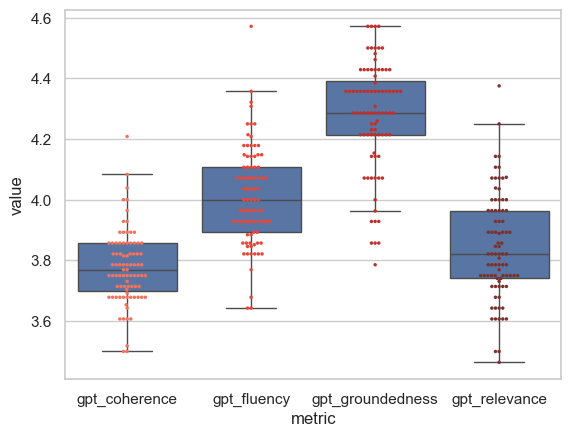

In [4]:
# plot scatter ploy for each metric
metrics =['gpt_coherence', 'gpt_fluency', 'gpt_groundedness','gpt_relevance']
import numpy as np
import pandas as pd
import os
data = df_all.groupby('Run').mean()
# melt the dataframe to make it easier to plot
data = data.reset_index()
data = pd.melt(data, id_vars=['Run'], value_vars=metrics, var_name='metric', value_name='value')

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
tips = sns.load_dataset("tips")

ax = sns.boxplot(x="metric", y="value", data=data, showfliers = False)
ax = sns.swarmplot(x="metric", y="value", data=data, hue="metric", size=2.5, palette="Reds_d", linewidth=0)

plt.show()


In [74]:
import random, itertools
from tqdm import tqdm
runs = df_all.Run.unique()
list(runs)
pairs = list(itertools.combinations(list(runs), 2))

def extract_experiments(df, treatment_name, control_name):
    treatment = df_all[df_all.Run == treatment_name]
    control = df_all[df_all.Run == control_name]
    # make sure they are aligned on the line number
    treatment = treatment.sort_values(by=['Line number'])
    control = control.sort_values(by=['Line number'])
    # remove lines that don't show up in both
    treatment = treatment[treatment['Line number'].isin(control['Line number'])]
    control = control[control['Line number'].isin(treatment['Line number'])]
    return treatment, control

results = pd.DataFrame()
for sample in tqdm(pairs):
    
    for metric in ['gpt_coherence', 'gpt_fluency', 'gpt_groundedness', 'gpt_relevance']:
        treatment, control = extract_experiments(df_all, sample[0], sample[1])
        result = run_t_test(metric, sample[0], sample[1], control, treatment)
        results = pd.concat([results, pd.DataFrame(result, index=[0])]) 

results



100%|██████████| 3486/3486 [00:39<00:00, 87.57it/s]


,metric,control,treatment,control_mean,treatment_mean,change_mean,p_value,ci_low,ci_high
0,gpt_coherence,eval_rerun_dzaunfhpnr_6.csv,eval_rerun_alhlentuaw_3.csv,3.678571,3.892857,0.214286,0.246278,-0.156698,0.585269
0,gpt_fluency,eval_rerun_dzaunfhpnr_6.csv,eval_rerun_alhlentuaw_3.csv,4.107143,4.178571,0.071429,0.769072,-0.422769,0.565626
0,gpt_groundedness,eval_rerun_dzaunfhpnr_6.csv,eval_rerun_alhlentuaw_3.csv,4.357143,4.285714,-0.071429,0.662916,-0.403965,0.261108
0,gpt_relevance,eval_rerun_dzaunfhpnr_6.csv,eval_rerun_alhlentuaw_3.csv,3.750000,4.000000,0.250000,0.198976,-0.139551,0.639551
0,gpt_coherence,eval_rerun_dzaunfhpnr_6.csv,eval_rerun_kwvihdjjbg_4.csv,3.692308,3.807692,0.115385,0.502060,-0.233513,0.464282
...,...,...,...,...,...,...,...,...,...
0,gpt_relevance,eval_rerun_dzaunfhpnr_9.csv,eval_rerun_dzaunfhpnr_8.csv,4.071429,3.750000,-0.321429,0.271977,-0.909529,0.266672
0,gpt_coherence,eval_rerun_xffzexqndf_0.csv,eval_rerun_dzaunfhpnr_8.csv,3.821429,3.714286,-0.107143,0.448614,-0.393048,0.178763
0,gpt_fluency,eval_rerun_xffzexqndf_0.csv,eval_rerun_dzaunfhpnr_8.csv,4.071429,3.928571,-0.142857,0.355111,-0.454395,0.168681
0,gpt_groundedness,eval_rerun_xffzexqndf_0.csv,eval_rerun_dzaunfhpnr_8.csv,4.357143,4.285714,-0.071429,0.787138,-0.608813,0.465956


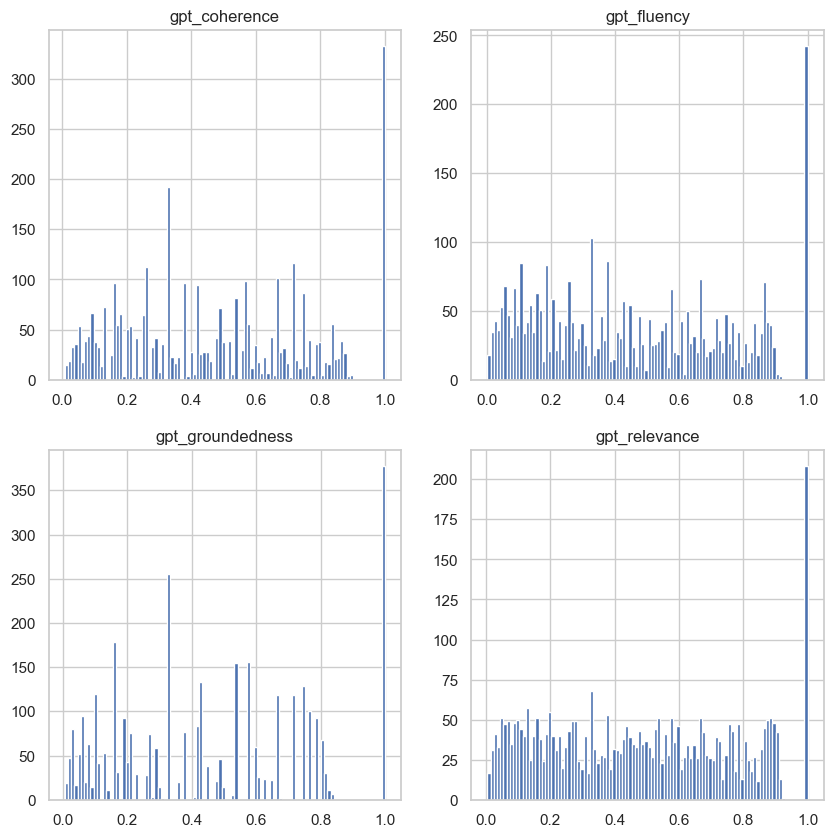

In [90]:


# make a 2 x 2 grid of histograms for each metric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, metric in enumerate(metrics):
    data = results[results.metric == metric]["p_value"]
    axs[i].hist(data, bins=100)
    axs[i].set_title(metric)
plt.show()

In [ ]:
# read all the data from the csv files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats

# read the data from the csvs files in the folder
data = pd.DataFrame()
for file in os.listdir("."):
    if file.startswith("Output") and file.endswith(".csv"):
        records = pd.read_csv(file)
        records['step'] = file[18:-4]
        # append the records to the data
        data  = pd.concat([data, records], ignore_index=True)

# group the data by step and aggregate gpt_coherence	gpt_fluency	gpt_groundedness	gpt_relevance
metrics = {}
for metric in ['gpt_coherence', 'gpt_fluency', 'gpt_groundedness', 'gpt_relevance']:
    metric_data = data[['step', metric]].copy()
    metric_data[metric] = metric_data.apply(lambda x: pd.to_numeric(x[metric], errors='coerce'), axis=1)
    #metric_data = metric_data.dropna()
    metrics[metric] = metric_data

# for each metric, do a t-test btw each of the steps in increasing order
# 0_baseline, 1_system_prompt, 2_chunk_size, 3_infer_intent
results = []
for metric, metric_data in metrics.items():
    steps = metric_data['step'].unique()
    steps.sort()
    for i in range(len(steps)-1):
        control = metric_data[metric_data['step'] == steps[i]]
        treatment = metric_data[metric_data['step'] == steps[i+1]]
        results.append(run_t_test(metric, steps[i], steps[i+1], control, treatment))
    # now compare the first and the last:
    control = metric_data[metric_data['step'] == steps[0]]
    treatment = metric_data[metric_data['step'] == steps[-1]]
    results.append(run_t_test(metric, steps[0], steps[-1], control, treatment))
    
# create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

In [7]:
#create a random string for the run name
import random
import string
import promptflow as pf
import pandas as pd

def random_string(stringLength=10):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength))

run_suffix = random_string(10)
flow="../../src/rag_flow_0/"
cli = pf.PFClient()

for i in range(25):
    run_name = f"rerun_{run_suffix}_{i}"
    print(run_name)
    rag_run = cli.run(  flow=flow,
                        data="../../data/prompt_input/questions.jsonl",
                        column_mapping={"chat_history": "${data.chat_history}", "question": "${data.question}"},
                        name=run_name)

    eval_name = f"eval_{run_name}"
    print("Eval Run:", eval_name)

    eval_run = cli.run( flow="../../src/eval_flow/",
                        run=run_name,
                        column_mapping={"chat_history": "${run.inputs.chat_history}", 
                                        "question": "${run.inputs.question}",
                                        "answer": "${run.outputs.answer}",
                                        "context": "${run.outputs.context}"},
                        name=eval_name)

    rag_output = pd.read_json(f"{rag_run._output_path}/flow_outputs/output.jsonl", lines=True)  
    eval_output = pd.read_json(f"{eval_run._output_path}/flow_outputs/output.jsonl", lines=True)

    # merge rag and eval output on line_number
    merged_output = pd.merge(rag_output, eval_output, on="line_number", suffixes=("_rag", "_eval"))
    merged_output["flow"] = flow
    merged_output["run_name"] = run_name
    merged_output.to_csv(f"{eval_name}.csv", index=False)
    logger.info(f"Saved merged result as csv to {eval_name}.csv")

rerun_qduugbyqed_0
2023-10-30 17:36:50 +0100   57820 execution          INFO     Process 57820 started.
Eval Run: eval_rerun_qduugbyqed_0
2023-10-30 17:38:14 +0100   57852 execution          INFO     Process 57852 started.


2023-10-30 17:39:10,225 Saved merged result as csv to eval_rerun_qduugbyqed_0.csv


rerun_qduugbyqed_1
2023-10-30 17:39:12 +0100   57869 execution          INFO     Process 57869 started.
Eval Run: eval_rerun_qduugbyqed_1
2023-10-30 17:40:39 +0100   57883 execution          INFO     Process 57883 started.


2023-10-30 17:41:34,394 Saved merged result as csv to eval_rerun_qduugbyqed_1.csv


rerun_qduugbyqed_2
2023-10-30 17:41:37 +0100   57904 execution          INFO     Process 57904 started.
Eval Run: eval_rerun_qduugbyqed_2
2023-10-30 17:43:03 +0100   57941 execution          INFO     Process 57941 started.


2023-10-30 17:43:57,585 Saved merged result as csv to eval_rerun_qduugbyqed_2.csv


rerun_qduugbyqed_3
2023-10-30 17:44:00 +0100   57955 execution          INFO     Process 57955 started.
Eval Run: eval_rerun_qduugbyqed_3
2023-10-30 17:45:19 +0100   58001 execution          INFO     Process 58001 started.


2023-10-30 17:46:10,887 Saved merged result as csv to eval_rerun_qduugbyqed_3.csv


rerun_qduugbyqed_4
2023-10-30 17:46:14 +0100   58012 execution          INFO     Process 58012 started.
Eval Run: eval_rerun_qduugbyqed_4
2023-10-30 17:47:41 +0100   58032 execution          INFO     Process 58032 started.
2023-10-30 17:58:08 +0100   58234 execution          INFO     Process 58234 started.


[2023-10-30 17:58:35,651][promptflow._sdk.operations._run_submitter][WARNING] - 1 out of 28 runs failed in bulk run. Please check out /Users/danielsc/.promptflow/.runs/eval_rerun_qduugbyqed_4 for more details.
2023-10-30 17:58:35,858 Saved merged result as csv to eval_rerun_qduugbyqed_4.csv


rerun_qduugbyqed_5
2023-10-30 17:58:47 +0100   58249 execution          INFO     Process 58249 started.
Eval Run: eval_rerun_qduugbyqed_5
2023-10-30 18:00:13 +0100   58267 execution          INFO     Process 58267 started.


2023-10-30 18:01:08,043 Saved merged result as csv to eval_rerun_qduugbyqed_5.csv


rerun_qduugbyqed_6
2023-10-30 18:01:10 +0100   58278 execution          INFO     Process 58278 started.
Eval Run: eval_rerun_qduugbyqed_6
2023-10-30 18:02:32 +0100   58325 execution          INFO     Process 58325 started.


2023-10-30 18:03:27,548 Saved merged result as csv to eval_rerun_qduugbyqed_6.csv


rerun_qduugbyqed_7
2023-10-30 18:03:30 +0100   58357 execution          INFO     Process 58357 started.
Eval Run: eval_rerun_qduugbyqed_7
2023-10-30 18:04:52 +0100   58376 execution          INFO     Process 58376 started.


2023-10-30 18:05:42,705 Saved merged result as csv to eval_rerun_qduugbyqed_7.csv


rerun_qduugbyqed_8
2023-10-30 18:05:45 +0100   58390 execution          INFO     Process 58390 started.
Eval Run: eval_rerun_qduugbyqed_8
2023-10-30 18:07:12 +0100   58421 execution          INFO     Process 58421 started.


2023-10-30 18:08:08,501 Saved merged result as csv to eval_rerun_qduugbyqed_8.csv


rerun_qduugbyqed_9
2023-10-30 18:08:11 +0100   58452 execution          INFO     Process 58452 started.
Eval Run: eval_rerun_qduugbyqed_9
2023-10-30 18:09:31 +0100   58474 execution          INFO     Process 58474 started.


2023-10-30 18:10:22,343 Saved merged result as csv to eval_rerun_qduugbyqed_9.csv


rerun_qduugbyqed_10
2023-10-30 18:10:24 +0100   58487 execution          INFO     Process 58487 started.
Eval Run: eval_rerun_qduugbyqed_10
2023-10-30 18:11:52 +0100   58509 execution          INFO     Process 58509 started.


2023-10-30 18:12:44,147 Saved merged result as csv to eval_rerun_qduugbyqed_10.csv


rerun_qduugbyqed_11
2023-10-30 18:12:48 +0100   58552 execution          INFO     Process 58552 started.
Eval Run: eval_rerun_qduugbyqed_11
2023-10-30 18:14:23 +0100   58649 execution          INFO     Process 58649 started.


2023-10-30 18:15:19,269 Saved merged result as csv to eval_rerun_qduugbyqed_11.csv


rerun_qduugbyqed_12
2023-10-30 18:15:22 +0100   58672 execution          INFO     Process 58672 started.
Eval Run: eval_rerun_qduugbyqed_12
2023-10-30 18:16:44 +0100   58765 execution          INFO     Process 58765 started.


2023-10-30 18:17:30,198 Saved merged result as csv to eval_rerun_qduugbyqed_12.csv


rerun_qduugbyqed_13
2023-10-30 18:17:33 +0100   58845 execution          INFO     Process 58845 started.
Eval Run: eval_rerun_qduugbyqed_13
2023-10-30 18:18:52 +0100   58926 execution          INFO     Process 58926 started.


2023-10-30 18:19:38,431 Saved merged result as csv to eval_rerun_qduugbyqed_13.csv


rerun_qduugbyqed_14
2023-10-30 18:19:41 +0100   58955 execution          INFO     Process 58955 started.
Eval Run: eval_rerun_qduugbyqed_14
2023-10-30 18:20:59 +0100   58971 execution          INFO     Process 58971 started.


2023-10-30 18:21:54,776 Saved merged result as csv to eval_rerun_qduugbyqed_14.csv


rerun_qduugbyqed_15
2023-10-30 18:21:57 +0100   58982 execution          INFO     Process 58982 started.
Eval Run: eval_rerun_qduugbyqed_15
2023-10-30 18:23:18 +0100   59069 execution          INFO     Process 59069 started.


2023-10-30 18:24:05,394 Saved merged result as csv to eval_rerun_qduugbyqed_15.csv


rerun_qduugbyqed_16
2023-10-30 18:24:08 +0100   59080 execution          INFO     Process 59080 started.
Eval Run: eval_rerun_qduugbyqed_16
2023-10-30 18:25:27 +0100   59112 execution          INFO     Process 59112 started.


2023-10-30 18:26:16,526 Saved merged result as csv to eval_rerun_qduugbyqed_16.csv


rerun_qduugbyqed_17
2023-10-30 18:26:19 +0100   59137 execution          INFO     Process 59137 started.
Eval Run: eval_rerun_qduugbyqed_17
2023-10-30 18:27:44 +0100   59157 execution          INFO     Process 59157 started.


2023-10-30 18:28:31,207 Saved merged result as csv to eval_rerun_qduugbyqed_17.csv


rerun_qduugbyqed_18
2023-10-30 18:28:38 +0100   59244 execution          INFO     Process 59244 started.
Eval Run: eval_rerun_qduugbyqed_18
2023-10-30 18:29:58 +0100   59332 execution          INFO     Process 59332 started.


2023-10-30 18:30:45,884 Saved merged result as csv to eval_rerun_qduugbyqed_18.csv


rerun_qduugbyqed_19
2023-10-30 18:30:48 +0100   59340 execution          INFO     Process 59340 started.
Eval Run: eval_rerun_qduugbyqed_19
2023-10-30 18:32:11 +0100   59410 execution          INFO     Process 59410 started.


2023-10-30 18:33:09,495 Saved merged result as csv to eval_rerun_qduugbyqed_19.csv


rerun_qduugbyqed_20
2023-10-30 18:33:12 +0100   59438 execution          INFO     Process 59438 started.
2023-10-30 18:49:39 +0100   59477 execution          INFO     Process 59477 started.


[2023-10-30 18:50:41,373][promptflow._sdk.operations._run_submitter][WARNING] - 1 out of 28 runs failed in bulk run. Please check out /Users/danielsc/.promptflow/.runs/rerun_qduugbyqed_20 for more details.


Eval Run: eval_rerun_qduugbyqed_20
2023-10-30 18:50:46 +0100   59580 execution          INFO     Process 59580 started.


2023-10-30 18:51:41,406 Saved merged result as csv to eval_rerun_qduugbyqed_20.csv


rerun_qduugbyqed_21
2023-10-30 18:51:44 +0100   59620 execution          INFO     Process 59620 started.
Eval Run: eval_rerun_qduugbyqed_21
2023-10-30 18:53:04 +0100   59632 execution          INFO     Process 59632 started.


2023-10-30 18:53:53,269 Saved merged result as csv to eval_rerun_qduugbyqed_21.csv


rerun_qduugbyqed_22
2023-10-30 18:53:56 +0100   59639 execution          INFO     Process 59639 started.
Eval Run: eval_rerun_qduugbyqed_22
2023-10-30 18:55:17 +0100   59661 execution          INFO     Process 59661 started.


2023-10-30 18:56:04,735 Saved merged result as csv to eval_rerun_qduugbyqed_22.csv


rerun_qduugbyqed_23
2023-10-30 18:56:08 +0100   59667 execution          INFO     Process 59667 started.
Eval Run: eval_rerun_qduugbyqed_23
2023-10-30 18:57:29 +0100   59690 execution          INFO     Process 59690 started.


2023-10-30 18:58:20,862 Saved merged result as csv to eval_rerun_qduugbyqed_23.csv


rerun_qduugbyqed_24
2023-10-30 18:58:24 +0100   59713 execution          INFO     Process 59713 started.
2023-10-30 19:08:51 +0100   60016 execution          INFO     Process 60016 started.


[2023-10-30 19:09:48,303][promptflow._sdk.operations._run_submitter][WARNING] - 1 out of 28 runs failed in bulk run. Please check out /Users/danielsc/.promptflow/.runs/rerun_qduugbyqed_24 for more details.


Eval Run: eval_rerun_qduugbyqed_24
2023-10-30 19:09:52 +0100   60042 execution          INFO     Process 60042 started.


2023-10-30 19:10:48,965 Saved merged result as csv to eval_rerun_qduugbyqed_24.csv


In [8]:

import pandas as pd
# list all files in the current directory that start with "eval_rerun"
import os
folder = '.'
files = os.listdir(folder)
files = [f for f in files if f.startswith("eval_rerun")]
df_all = pd.DataFrame()
for file in files:
    data = pd.read_csv(f"{folder}/{file}", dtype={'line_number': 'int64'})
    df = pd.DataFrame(data)
    df["Run"] = file
    df_all = pd.concat([df_all, df])

# group by Run, then aggrate mean
summary = df_all.groupby('run_musiname').mean()
summary.describe()

/var/folders/kr/95w6h7_j311dvwwhrtydhzj00000gn/T/ipykernel_54837/714055299.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  summary = df_all.groupby('run_name').mean()


,line_number,gpt_coherence,gpt_fluency,gpt_groundedness,gpt_relevance
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,13.509804,4.686326,4.701084,2.591607,2.684070
std,0.051099,0.035962,0.038715,0.038610,0.077303
min,13.481481,4.607143,4.607143,2.481481,2.500000
25%,13.500000,4.642857,4.678571,2.571429,2.642857
50%,13.500000,4.714286,4.714286,2.571429,2.678571
75%,13.500000,4.714286,4.714286,2.642857,2.714286
max,13.777778,4.750000,4.750000,2.703704,2.892857
